# TensorFlow2 最新迁移学习教程和实战
https://mp.weixin.qq.com/s/RflR0PgDpj1T4qLdPkRUKA

https://rubikscode.net/2019/11/11/transfer-learning-with-tensorflow-2/

【导读】阅读深度学习的科学论文总是很有趣且富有教育意义。尤其是当它在你正在工作的当前项目的区域中时。但是，这些论文通常包含难以训练的体系结构和解决方案。特别是如果你想尝试，比如说，ImageNet大型视觉识别（ILSCVR）比赛的一些优胜者。我可以记得读过有关VGG16的文章，并想过“这太酷了，但是我的GPU将会死掉”。为了使我们的生活更轻松，TensorFlow 2提供了许多预先训练的模型，您可以快速使用它们。在本文中，我们将探讨如何使用一些著名的卷积神经网络框架来做到这一点。

       此时，人们可能会想：“什么是预训练模型？”。 本质上，预训练模型是一个保存的网络，该网络先前已在某个大型数据集（例如ImageNet数据集）上进行了训练。 它们可以在tensorflow.keras.applications模块中找到。 有两种方法可以使用它们。 你可以把它作为开箱即用的解决方案，也可以把它用于转移学习。 由于大型数据集通常用于某些全局解决方案，因此您可以自定义预训练模型并将其专门用于某些问题。 这样，您可以利用一些最著名的神经网络，而不会浪费太多的时间和训练资源。 此外，您可以通过修改所选图层的行为来微调这些模型。 这将在以后的文章中介绍。
       

# Architectures

在本文中，我们使用三个预先训练的模型来求解分类示例：VGG16，GoogLeNet（Inception）和ResNet。这些框架中的每一个都是ILSCVR竞赛的获胜者。VGG16在2014年与GoogLeNet一起获得了最佳成绩，而ResNet在2015年赢得了冠军。这些模型是TensorFlow 2（即tensorflow.keras.applications）模块的一部分。让我们更深入地了解一下这些框架。
## VGG16
      VGG16是我们考虑的第一个架构。它是K.Simonyan和a.Zisserman在《用于大规模图像识别的非常深卷积网络》一文中提出的一种大型卷积神经网络。该网络在ImageNet数据集中实现了92.7％的top-5测试准确性。但是，它经过了数周的训练。这是该模型的高级概述：

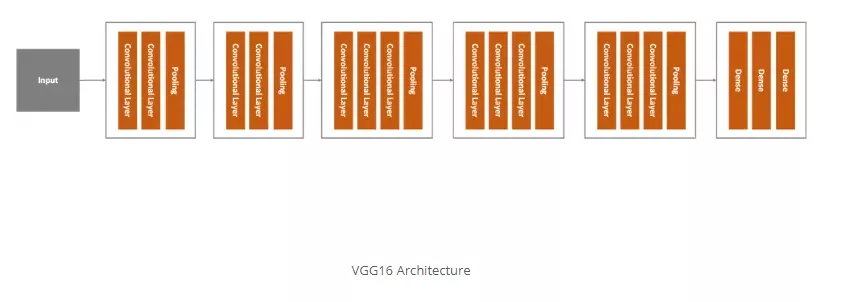

## GoogLeNet也称为Inception
GoogLeNet也称为Inception。这是因为它利用了两个概念：1×1卷积和初始模块。第一个概念1×1卷积用作降维模块。通过减少维数，计算量也会减少，这意味着可以增加网络的深度和宽度。GoogLeNet并未使用每个卷积层的固定大小，而是使用了Inception模块：
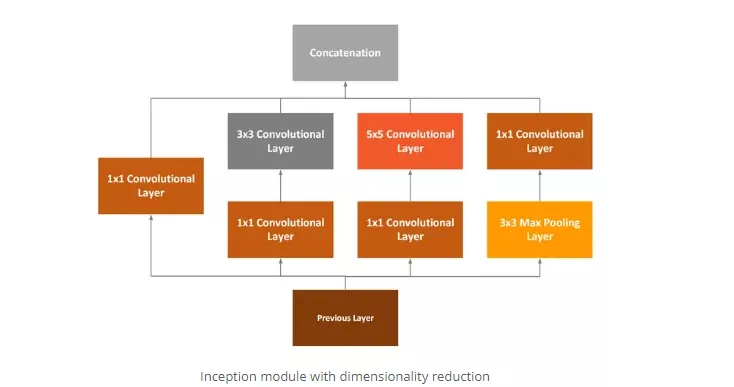
如您所见，1×1卷积层，3×3卷积层，5×5卷积层和3×3最大池化层一起执行它们的操作，然后将它们的结果再次在输出时堆叠在一起。GoogLeNet总共有22层，看起来像这样：

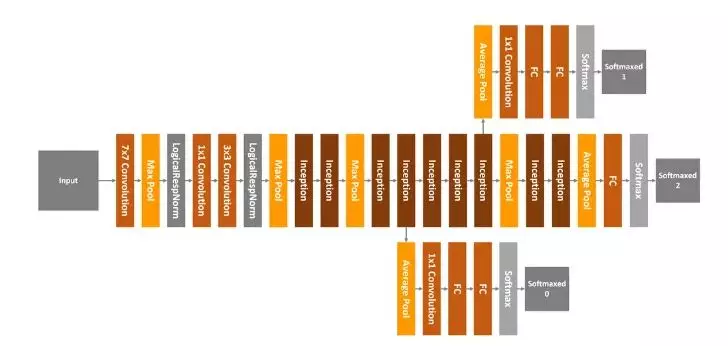

## 残差网络或ResNet
残差网络或ResNet是我们在本文中将要使用的最终体系框架。以前的框架存在的问题是它们很深。它们有很多层，因此很难训练（逐渐消失的梯度）。因此，ResNet通过所谓的“身份快捷方式连接”或剩余块解决了该问题：
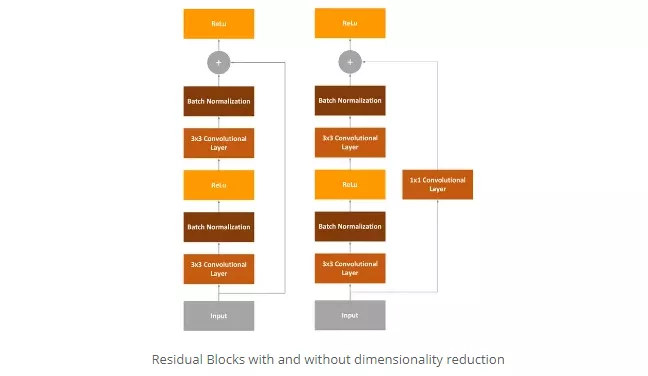

本质上，ResNet遵循VGG的3×3卷积层设计，其中每个卷积层后面都有一个批处理归一化层和ReLU激活功能。但是，不同之处在于，在最终ReLu之前，我们向ResNet注入了输入。变体之一是，输入值通过1×1卷积层。

# Dataset

在本文中，我们使用“猫与狗”数据集。该数据集包含23,262张猫和狗的图像。
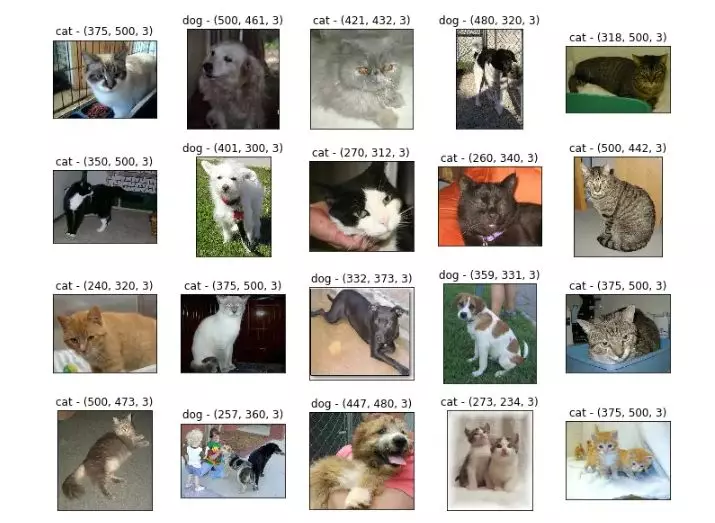

您可能会注意到图像没有被标准化，并且它们具有不同的形状。很棒的事情是，它可以作为TensorFlow数据集的一部分使用。因此，请确保已在您的环境中安装了TensorFlow数据集：

pip install tensorflow-datasets

      与库中的其他数据集不同，此数据集未分为训练数据和测试数据，因此我们需要自己执行拆分。您可以在此处找到有关数据集的更多信息。

In [5]:
!pip freeze | grep tensorflow-datasets

tensorflow-datasets==1.3.0


# Implementation
此实现分为几个部分。首先，我们实现负责加载数据并准备数据的类。然后，我们导入经过预训练的模型并构建一个可修改其顶层的类。最后，我们运行训练过程和评估过程。当然，在一切之前，我们必须导入一些库并定义一些全局常量：

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

IMG_SIZE = 160
BATCH_SIZE = 32
SHUFFLE_SIZE = 1000
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Data Loader

In [21]:
class DataLoader(object):
    def __init__(self, image_size, batch_size):
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        # 80% train data, 10% validation data, 10% test data
        split_weights = (8, 1, 1)
        splits = tfds.Split.TRAIN.subsplit(weighted=split_weights)
        
        (self.train_data_raw, self.validation_data_raw, self.test_data_raw), self.metadata = tfds.load(
            'cats_vs_dogs', split=list(splits),
            with_info=True, as_supervised=True)
        
        # Get the number of train examples
        self.num_train_examples = self.metadata.splits['train'].num_examples*80/100
        self.get_label_name = self.metadata.features['label'].int2str
        
        # Pre-process data
        self._prepare_data()
        self._prepare_batches()
        
    # Resize all images to image_size x image_size
    def _prepare_data(self):
        self.train_data = self.train_data_raw.map(self._resize_sample)
        self.validation_data = self.validation_data_raw.map(self._resize_sample)
        self.test_data = self.test_data_raw.map(self._resize_sample)
    
    # Resize one image to image_size x image_size
    def _resize_sample(self, image, label):
        image = tf.cast(image, tf.float32)
        image = (image/127.5) - 1
        image = tf.image.resize(image, (self.image_size, self.image_size))
        return image, label
    
    def _prepare_batches(self):
        self.train_batches = self.train_data.shuffle(1000).batch(self.batch_size)
        self.validation_batches = self.validation_data.batch(self.batch_size)
        self.test_batches = self.test_data.batch(self.batch_size)
   
    # Get defined number of  not processed images
    def get_random_raw_images(self, num_of_images):
        random_train_data_raw = self.train_data_raw.shuffle(1000)
        return random_train_data_raw.take(num_of_images)

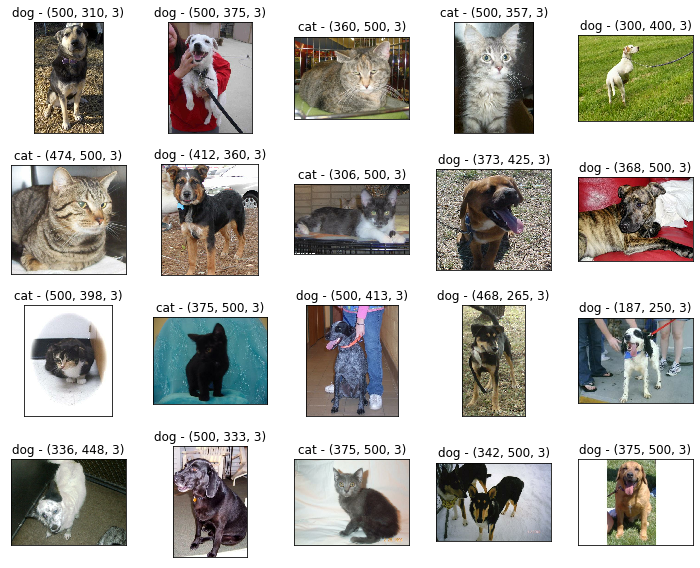

In [22]:
data_loader = DataLoader(IMG_SIZE, BATCH_SIZE)

plt.figure(figsize=(10, 8))
i = 0
for img, label in data_loader.get_random_raw_images(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title("{} - {}".format(data_loader.get_label_name(label), img.shape))
    plt.xticks([])
    plt.yticks([])
    i += 1
plt.tight_layout()
plt.show()

# Base Models & Wrapper
Next thing on our list is loading of the pre-trained models. As we already mentioned these models are located in tensorflow.kearas.applications. Loading them is pretty straight forward:

In [15]:
vgg16_base = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
googlenet_base = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
resnet_base = tf.keras.applications.ResNet101V2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

171319296/171317808 [==============================] - 212s 1us/step


这就是我们创建感兴趣的三种架构的基础模型的方式。 注意，对于每个模型，include_top参数均定义为False。 这意味着这些模型用于特征提取。 一旦有了它们，我们需要修改这些模型的顶层，以便将它们应用于我们的具体问题。 我们使用Wrapper类来实现。 此类接受注入的预训练模型，并添加一个全局平均轮询层和一个密集层。 本质上，最后的Dense层用于我们的二进制分类（汽车或狗）。 包装器类将所有这些东西放到一个模型中：

In [16]:
class Wrapper(tf.keras.Model):
    def __init__(self, base_model):
        super(Wrapper, self).__init__()
        
        self.base_model = base_model
        self.average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        x = self.base_model(inputs)
        x = self.average_pooling_layer(x)
        output = self.output_layer(x)
        return output

然后，我们可以创建用于分类猫与狗数据集的真实模型并编译这些模型：

In [17]:
base_learning_rate = 0.0001

vgg16_base.trainable = False
vgg16 = Wrapper(vgg16_base)
vgg16.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

googlenet_base.trainable = False
googlenet = Wrapper(googlenet_base)
googlenet.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

resnet_base.trainable = False
resnet = Wrapper(resnet_base)
resnet.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

请注意，我们已将基本模型标记为不可训练。 这意味着在训练过程中，我们将只训练添加的顶层，而底层的权重不会改变。

# Training
Before we get into the whole training process, let’s reflect on the fact that in principle biggest part of these models is already trained. So, what we can do is perform evaluation process and see where we land:

In [18]:
loss1, accuracy1 = vgg16.evaluate(data_loader.validation_batches, steps = 20)
loss2, accuracy2 = googlenet.evaluate(data_loader.validation_batches, steps = 20)
loss3, accuracy3 = resnet.evaluate(data_loader.validation_batches, steps = 20)

print("--------VGG16---------")
print("Initial loss: {:.2f}".format(loss1))
print("Initial accuracy: {:.2f}".format(accuracy1))
print("---------------------------")

print("--------GoogLeNet---------")
print("Initial loss: {:.2f}".format(loss2))
print("Initial accuracy: {:.2f}".format(accuracy2))
print("---------------------------")

print("--------ResNet---------")
print("Initial loss: {:.2f}".format(loss3))
print("Initial accuracy: {:.2f}".format(accuracy3))
print("---------------------------")

20/20 [==============================] - 64s 3s/step - loss: 5.9341 - accuracy: 0.5625
--------VGG16---------
Initial loss: 1.12
Initial accuracy: 0.47
---------------------------
--------GoogLeNet---------
Initial loss: 5.08
Initial accuracy: 0.55
---------------------------
--------ResNet---------
Initial loss: 5.93
Initial accuracy: 0.56
---------------------------


It is interesting that without prior training of any of these models, we get ok-ish results (50% accuracy):

Starting with 50% accuracy is not bad thing at all. So, let’s run training process and see are we getting any better. First we train VGG16:

In [23]:
history = vgg16.fit(data_loader.train_batches,
                    epochs=10,
                    validation_data=data_loader.validation_batches)

Epoch 1/10
582/582 [==============================] - 2557s 4s/step - loss: 0.2967 - accuracy: 0.8880 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 2470s 4s/step - loss: 0.2557 - accuracy: 0.9082 - val_loss: 0.2274 - val_accuracy: 0.9159
Epoch 3/10
582/582 [==============================] - 2468s 4s/step - loss: 0.2348 - accuracy: 0.9164 - val_loss: 0.2171 - val_accuracy: 0.9198
Epoch 4/10
582/582 [==============================] - 2467s 4s/step - loss: 0.2208 - accuracy: 0.9211 - val_loss: 0.2054 - val_accuracy: 0.9254
Epoch 5/10
582/582 [==============================] - 2466s 4s/step - loss: 0.2114 - accuracy: 0.9248 - val_loss: 0.2004 - val_accuracy: 0.9315
Epoch 6/10
582/582 [==============================] - 2466s 4s/step - loss: 0.2091 - accuracy: 0.9275 - val_loss: 0.1930 - val_accuracy: 0.9323
Epoch 7/10
582/582 [==============================] - 2468s 4s/step - loss: 0.2050 - accuracy: 0.9299 - val_loss: 0.1894 - val_a

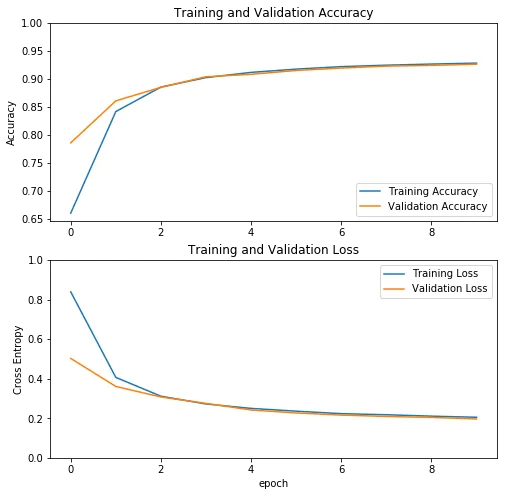

In [24]:
history = googlenet.fit(data_loader.train_batches,
                    epochs=10,
                    validation_data=data_loader.validation_batches)

Epoch 1/10
582/582 [==============================] - 597s 1s/step - loss: 2.3847 - accuracy: 0.6065 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 594s 1s/step - loss: 1.5821 - accuracy: 0.7031 - val_loss: 1.0710 - val_accuracy: 0.9073
Epoch 3/10
582/582 [==============================] - 593s 1s/step - loss: 1.1973 - accuracy: 0.7593 - val_loss: 0.9994 - val_accuracy: 0.9194
Epoch 4/10
582/582 [==============================] - 593s 1s/step - loss: 1.0078 - accuracy: 0.7883 - val_loss: 1.0180 - val_accuracy: 0.9241
Epoch 5/10
582/582 [==============================] - 593s 1s/step - loss: 0.8974 - accuracy: 0.8036 - val_loss: 0.6766 - val_accuracy: 0.9418
Epoch 6/10
582/582 [==============================] - 593s 1s/step - loss: 0.8595 - accuracy: 0.8110 - val_loss: 0.6943 - val_accuracy: 0.9405
Epoch 7/10
582/582 [==============================] - 592s 1s/step - loss: 0.7901 - accuracy: 0.8251 - val_loss: 0.7085 - val_accuracy

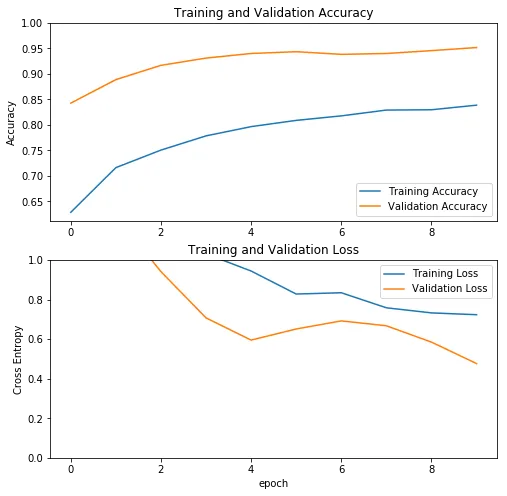

In [25]:
history = resnet.fit(data_loader.train_batches,
                    epochs=10,
                    validation_data=data_loader.validation_batches)

Epoch 1/10
582/582 [==============================] - 1790s 3s/step - loss: 2.6239 - accuracy: 0.6894 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 1786s 3s/step - loss: 1.4022 - accuracy: 0.8213 - val_loss: 0.7283 - val_accuracy: 0.9388
Epoch 3/10
582/582 [==============================] - 1787s 3s/step - loss: 1.0997 - accuracy: 0.8524 - val_loss: 0.5903 - val_accuracy: 0.9547
Epoch 4/10
582/582 [==============================] - 1787s 3s/step - loss: 0.9396 - accuracy: 0.8721 - val_loss: 0.5008 - val_accuracy: 0.9569
Epoch 5/10
582/582 [==============================] - 1788s 3s/step - loss: 0.8638 - accuracy: 0.8773 - val_loss: 0.4409 - val_accuracy: 0.9664
Epoch 6/10
582/582 [==============================] - 1787s 3s/step - loss: 0.7773 - accuracy: 0.8914 - val_loss: 0.4181 - val_accuracy: 0.9672
Epoch 7/10
582/582 [==============================] - 1788s 3s/step - loss: 0.7508 - accuracy: 0.8964 - val_loss: 0.4213 - val_a

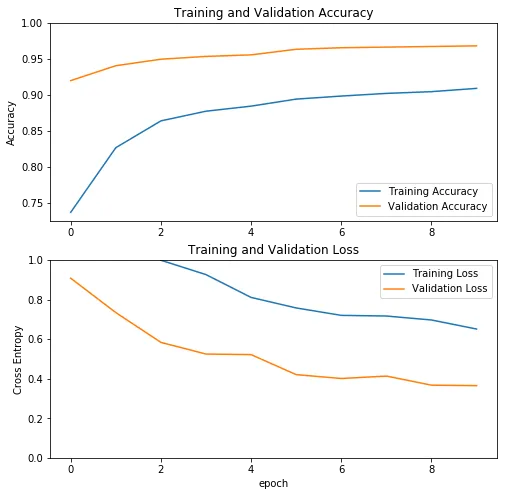

Training of these three models lasted just couple of hours, instead for weeks, thanks to the fact that we trained just top layers and not the whole network.

# Evaluation
We saw that in the begining, without any training we got around 50% of accuracy. Let’s see what is the situation after the training:

In [26]:
loss1, accuracy1 = vgg16.evaluate(data_loader.test_batches, steps = 20)
loss2, accuracy2 = googlenet.evaluate(data_loader.test_batches, steps = 20)
loss3, accuracy3 = resnet.evaluate(data_loader.test_batches, steps = 20)

print("--------VGG16---------")
print("Loss: {:.2f}".format(loss1))
print("Accuracy: {:.2f}".format(accuracy1))
print("---------------------------")

print("--------GoogLeNet---------")
print("Loss: {:.2f}".format(loss2))
print("Accuracy: {:.2f}".format(accuracy2))
print("---------------------------")

print("--------ResNet---------")
print("Loss: {:.2f}".format(loss3))
print("Accuracy: {:.2f}".format(accuracy3))
print("---------------------------")

20/20 [==============================] - 47s 2s/step - loss: 0.4031 - accuracy: 0.9641
--------VGG16---------
Loss: 0.25
Accuracy: 0.93
---------------------------
--------GoogLeNet---------
Loss: 0.40
Accuracy: 0.96
---------------------------
--------ResNet---------
Loss: 0.40
Accuracy: 0.96
---------------------------


# Conclusion
In this article, we demonstrated how to perform transfer learning with TensorFlow. We created a playground in which we can try out different pre- trained architectures on the data and get good results after just a matter of hours. In our example, we worked with three famous convolutional architectures and quickly modified them for specific problem. In next article, we will fine tune these models and check if we can get even better results.